In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def estimate_dth_lo(nth_hi=8, h_hi=0.05, dth_pole=0.3, max_rat=1.5):
    """
    Args:
        nth_hi: # of th cells over h_hi
        h_hi: high-res region thickness
        dth_pole: resolution at pole
        max_rat: max x2rat between cells
    Returns:
        nth_lo: minimum # of cells in low-res region
    """
    dth = h_hi/nth_hi
    th = h_hi
    nth_lo = 0
    while th<np.pi/2:
        dth *= max_rat
        dth = min(dth, dth_pole)
        nth_lo += 1
        th += dth
    print('minimum nth_lo: {}\nminimum total nth for [0,pi/2]: {}'.format(nth_lo, nth_hi+nth_lo))
    return nth_lo

In [3]:
from MeshGen import MeshGenOnePoint

def preview_grid(nth_lo=12, nth_hi=8, h_hi=0.05, dth_pole=0.3):
    """
    Args:
        nth_lo: # of th cells in low-res region [h_hi, pi/2]
        nth_hi: # of th cells over h_hi
        h_hi: high-res region thickness
        dth_pole: resolution at pole
    Return:
        None (plots grid and print max x2rat)
    """
    thf = (np.pi/2-np.array([MeshGenOnePoint(n, nth_lo, nth_hi, dth_pole, h_hi) for n in np.arange(nth_lo+nth_hi+1)]))[::-1]
    # plot grid
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal', 'box')
    rf = np.array([0.5, 1])
    xf, zf = rf[None,:]*np.sin(thf[:,None]), rf[None,:]*np.cos(thf[:,None])
    plt.pcolormesh(xf, zf, np.zeros((len(thf)-1, len(rf)-1))*np.nan, edgecolor='k', lw=.5)
    # print max x2rat
    dth = thf[1:]-thf[:-1]
    x2rat = dth[:-1]/dth[1:]
    print('total nth for [0,pi/2]: {}'.format(nth_hi+nth_lo))
    print('max x2rat: {}'.format(np.amax(x2rat)))
    return

In [4]:
def factor(a, b):
    # find largest c such that a = c*a1 and b = c*b1
    c = 1
    c_try = 1
    while c_try<a:
        c_try+=1
        if a%c_try==0 and b%c_try==0: c=c_try
    return c, a//c, b//c

In [5]:
def estimate_resolution(n_core=120, nth=48, dlogr=0.05/8, dphi=0.05/8, r_in=0.25, r_out=1.5):
    nphi_goal = np.pi*2 / dphi
    nr_goal = np.log(r_out/r_in) / np.log(1+dlogr)
    print('(nr, nth, nphi) for specified resolution: ({}, {}, {})'.format(int(nr_goal), nth, int(nphi_goal)))
    # modify nphi: slightly reduce from nphi_goal
    _, x, _ = factor(n_core, nth)
    nphi = int(nphi_goal/x) * x
    # modify nr: slightly increase from nr_goal
    nr = (int((nr_goal-1)/x)+1) * x
    _, y, _ = factor(n_core, nphi)
    while nr%y: nr+=x
    print('(nr, nth, nphi) after correction: ({}, {}, {})'.format(nr, nth, nphi))
    nc = int(nr*nth*nphi/n_core)
    print('n cell per meshblock = {} ~ {:.1f}^3'.format(nc, nc**(1/3)))

In [6]:
def optimize_meshblock(nr, nth, nphi, n_core):
    # sanity check
    if nth%factor(n_core, nr)[1] or nphi%factor(n_core, nr)[1] or nth%factor(n_core, nphi)[1]:
        print('does not satisfy remap requirements!')
        return
    # factorize
    f_min = np.inf
    n = [0,0,0]
    for n1 in range(1,n_core+1):
        if n_core%n1: continue
        for n2 in range(1,n_core//n1+1):
            if n_core%(n1*n2): continue
            n3 = n_core//(n1*n2)
            if nr%n1 or nth%n2 or nphi%n3: continue
            # how close to square?
            n_this = [nr//n1, nth//n2, nphi//n3]
            f_this = np.amax(n_this)/np.amin(n_this)
            if f_this<f_min:
                n = n_this
                f_min = f_this
    print('meshblock size: {} ~ {:.1f}^3'.format(n, np.prod(n)**(1/3)))
    return n

In [7]:
def generate_grid(
    nr=300, r_min=0.25, r_max=1.5,
    nphi=960,
    nth_lo=16, nth_hi=8, h_hi=0.05, dth_pole=0.3,
    n_core=480,
):
    dth_mid = h_hi/nth_hi
    x1rat = (r_max/r_min)**(1/nr)
    dphi = np.pi*2/nphi
    print('dlogr/dth_mid = {:.2f}'.format(np.log(x1rat)/dth_mid))
    print('dphi/dth_mid = {:.2f}'.format(dphi/dth_mid))
    nth = 2*(nth_lo+nth_hi)
    n = optimize_meshblock(nr, nth, nphi, n_core)
    print('\n\n\n')
    # generate mesh and meshblock sections of input file
    s = '\
<mesh>\n\
nx1        = {}\n\
x1min      = {}\n\
x1max      = {}\n\
x1rat      = {}\n\
ix1_bc     = outflow\n\
ox1_bc     = user\n\
\n\
nx2        = {}\n\
x2min      = 0.0\n\
x2max      = 3.1415926535897932\n\
x2rat      = -1 # user-defined mesh generator\n\
nth_lo     = {}\n\
nth_hi     = {}\n\
h_hi       = {}\n\
dth_pole   = {}\n\
ix2_bc     = polar\n\
ox2_bc     = polar\n\
\n\
nx3        = {}\n\
x3min      = 0.0\n\
x3max      = 6.283185307179586\n\
ix3_bc     = periodic\n\
ox3_bc     = periodic\n\
\n\
<meshblock>\n\
nx1        = {}\n\
nx2        = {}\n\
nx3        = {}\n\
    '.format(nr, r_min, r_max, x1rat,
             nth, nth_lo, nth_hi, h_hi, dth_pole,
             nphi,
             n[0],n[1],n[2])
    print(s)
    return

In [8]:
_ = estimate_dth_lo(nth_hi=64, h_hi=0.5, dth_pole=0.1, max_rat=1.5)

minimum nth_lo: 15
minimum total nth for [0,pi/2]: 79


total nth for [0,pi/2]: 80
max x2rat: 1.3600899096851702


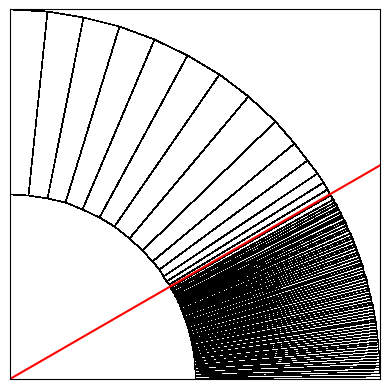

In [10]:
preview_grid(nth_lo=16, nth_hi=64, h_hi=0.5, dth_pole=0.1)
plt.plot([0,1],[0,np.tan(np.pi/6)], 'r')
plt.show()

In [16]:
estimate_resolution(n_core=120, nth=16, dlogr=0.05/2, dphi=0.05/2, r_in=0.25, r_out=2)

(nr, nth, nphi) for specified resolution: (84, 16, 251)
(nr, nth, nphi) after correction: (90, 16, 240)
n cell per meshblock = 2880 ~ 14.2^3


In [11]:
optimize_meshblock(nr=90, nth=16, nphi=240, n_core=16)

meshblock size: [45, 16, 30] ~ 27.8^3


[45, 16, 30]

In [19]:
generate_grid(
    nr=90, r_min=0.25, r_max=2,
    nphi=240,
    nth_lo=12, nth_hi=4, h_hi=0.05, dth_pole=0.3,
    n_core=120,
)

dlogr/dth_mid = 1.85
dphi/dth_mid = 2.09
meshblock size: [18, 16, 20] ~ 17.9^3




<mesh>
nx1        = 90
x1min      = 0.25
x1max      = 2
x1rat      = 1.023373891996775
ix1_bc     = outflow
ox1_bc     = user

nx2        = 32
x2min      = 0.0
x2max      = 3.1415926535897932
x2rat      = -1 # user-defined mesh generator
nth_lo     = 12
nth_hi     = 4
h_hi       = 0.05
dth_pole   = 0.3
ix2_bc     = polar
ox2_bc     = polar

nx3        = 240
x3min      = 0.0
x3max      = 6.283185307179586
ix3_bc     = periodic
ox3_bc     = periodic

<meshblock>
nx1        = 18
nx2        = 16
nx3        = 20
    


In [115]:
generate_grid(
    nr=300, r_min=0.25, r_max=1.5,
    nphi=960,
    nth_lo=16, nth_hi=8, h_hi=0.05, dth_pole=0.3,
    n_core=480,
)

dlogr/dth_mid = 0.96
dphi/dth_mid = 1.05
meshblock size: [30, 24, 40] ~ 30.7^3




<mesh>
nx1        = 300
x1min      = 0.25
x1max      = 1.5
x1rat      = 1.005990402691645
ix1_bc     = outflow
ox1_bc     = user

nx2        = 48
x2min      = 0.0
x2max      = 3.1415926535897932
x2rat      = -1 # user-defined mesh generator
nth_lo     = 16
nth_hi     = 8
h_hi       = 0.05
dth_pole   = 0.3
ix2_bc     = polar
ox2_bc     = polar

nx3        = 960
x3min      = 0.0
x3max      = 6.283185307179586
ix3_bc     = periodic
ox3_bc     = periodic

<meshblock>
nx1        = 30
nx2        = 24
nx3        = 40
    


In [9]:
generate_grid(
    nr=300, r_min=0.1, r_max=1.5,
    nphi=480,
    nth_lo=16, nth_hi=8, h_hi=0.05, dth_pole=0.3,
    n_core=480,
)

dlogr/dth_mid = 1.44
dphi/dth_mid = 2.09
meshblock size: [25, 24, 24] ~ 24.3^3




<mesh>
nx1        = 300
x1min      = 0.1
x1max      = 1.5
x1rat      = 1.0090676987369098
ix1_bc     = outflow
ox1_bc     = user

nx2        = 48
x2min      = 0.0
x2max      = 3.1415926535897932
x2rat      = -1 # user-defined mesh generator
nth_lo     = 16
nth_hi     = 8
h_hi       = 0.05
dth_pole   = 0.3
ix2_bc     = polar
ox2_bc     = polar

nx3        = 480
x3min      = 0.0
x3max      = 6.283185307179586
ix3_bc     = periodic
ox3_bc     = periodic

<meshblock>
nx1        = 25
nx2        = 24
nx3        = 24
    


In [10]:
generate_grid(
    nr=150, r_min=0.25, r_max=1.5,
    nphi=480,
    nth_lo=16, nth_hi=8, h_hi=0.05, dth_pole=0.3,
    n_core=240,
)

dlogr/dth_mid = 1.91
dphi/dth_mid = 2.09
meshblock size: [25, 24, 24] ~ 24.3^3




<mesh>
nx1        = 150
x1min      = 0.25
x1max      = 1.5
x1rat      = 1.0120166903076984
ix1_bc     = outflow
ox1_bc     = user

nx2        = 48
x2min      = 0.0
x2max      = 3.1415926535897932
x2rat      = -1 # user-defined mesh generator
nth_lo     = 16
nth_hi     = 8
h_hi       = 0.05
dth_pole   = 0.3
ix2_bc     = polar
ox2_bc     = polar

nx3        = 480
x3min      = 0.0
x3max      = 6.283185307179586
ix3_bc     = periodic
ox3_bc     = periodic

<meshblock>
nx1        = 25
nx2        = 24
nx3        = 24
    


In [9]:
optimize_meshblock(nr=480, nth=32, nphi=240, n_core=480)

meshblock size: [24, 16, 20] ~ 19.7^3


[24, 16, 20]